In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import os
from math import * 
os.getcwd()
print("The current directory is: ")
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print("Moving up to the parent directory")
print(os.getcwd())

The current directory is: 
c:\Users\springnuance\Desktop\Abaqus-Macromechanics-Project\notebooks
Moving up to the parent directory
c:\Users\springnuance\Desktop\Abaqus-Macromechanics-Project


In [3]:
from stage0_configs import *
info = main_config()


Welcome to the Abaqus parameter calibration project


The configurations you have chosen: 

+------------------------+-------------+
|     Global Configs     | User choice |
+------------------------+-------------+
| Number of initial sims |      20     |
|  Initial sims spacing  |     1000    |
|   Optimize strategy    |     SOO     |
|        Material        | DP1000_room |
|     Hardening law      |  SwiftVoce  |
|        Geometry        |    NDBR50   |
|      Curve index       |      2      |
|     Optimizer name     |      BO     |
|   Deviation percent    |      5      |
+------------------------+-------------+

Generating necessary directories

The path to your main project folder is

c:\Users\springnuance\Desktop\Abaqus-Macromechanics-Project



In [4]:
targetPath = info['targetPath']
target = pd.read_csv(f"{targetPath}/FD_Curve.csv")
target['force/N'] = target['force/kN'] * 1000
# Save as a csv file
target.to_csv(f"{targetPath}/Force-Displacement.csv", index=False)

In [5]:
resultPath = info['resultPath']
targetPath = info['targetPath']
# Load csv file
target = pd.read_csv(f"{targetPath}/FD_Curve.csv")
expForce = target['force/N'].to_numpy()
expDisplacement = target['displacement/mm'].to_numpy() 
#print(max(expDisplacement))
targetCurve = {}
targetCurve['displacement'] = expDisplacement
targetCurve['force'] = expForce

initial_original_FD_Curves = np.load(f"{resultPath}/initial/common/FD_Curves.npy", allow_pickle=True).tolist()
initial_interpolated_FD_Curves = interpolating_FD_Curves(initial_original_FD_Curves, targetCurve)
print(list(initial_interpolated_FD_Curves.values())[0]['displacement'])


# print(maxDisp)
# Plotting all FD curves
figure(figsize=(8, 6), dpi=80)
plt.plot(expDisplacement, expForce, label='Experiment')
for param in initial_interpolated_FD_Curves:
    plt.plot(initial_interpolated_FD_Curves[param]['displacement'], initial_interpolated_FD_Curves[param]['force'], color='orange', alpha=0.5,
             #label=param
             )
plt.plot([],[], color='orange', alpha=0.5, label='Initial guesses')
plt.title('Exp and Interpolated Sim Force-Displacement Curves')
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (N)')
plt.legend()

# print(maxDisp)
# Plotting all FD curves
figure(figsize=(8, 6), dpi=80)
plt.plot(expDisplacement, expForce, label='Experiment')
for param in initial_original_FD_Curves:
    plt.plot(initial_original_FD_Curves[param]['displacement'], initial_original_FD_Curves[param]['force'], color='orange', alpha=0.5,
             #label=param
             )
plt.plot([],[], color='orange', alpha=0.5, label='Initial guesses')
plt.title('Exp and Original Sim Force-Displacement Curves')
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (N)')
plt.legend()

iteration_original_FD_Curves = np.load(f"{resultPath}/iteration/common/FD_Curves.npy", allow_pickle=True).tolist()
print(list(iteration_original_FD_Curves.keys())[-1])

KeyError: 'force/N'

(('c1', 1529.916382540723), ('c2', 0.0004917216870191625), ('c3', 0.10379683592069525))


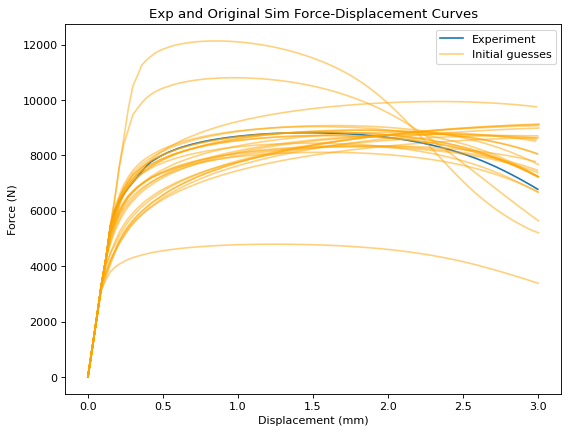

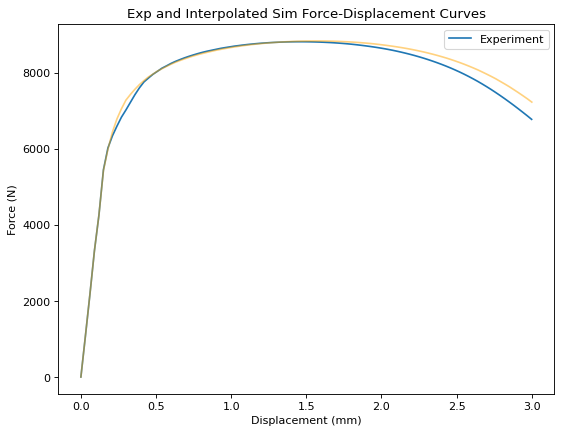

In [ ]:
# Do the same like cell above but for iteration
# Plotting all FD curves
figure(figsize=(8, 6), dpi=80)
plt.plot(expDisplacement, expForce, label='Experiment')
for param in iteration_original_FD_Curves:
    plt.plot(iteration_original_FD_Curves[param]['displacement'], iteration_original_FD_Curves[param]['force'], color='orange', alpha=0.5,
             #label=param
             )
plt.plot([],[], color='orange', alpha=0.5, label='Initial guesses')
plt.title('Exp and Original Sim Force-Displacement Curves')
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (N)')
plt.legend()

iteration_interpolated_FD_Curves = interpolating_FD_Curves(iteration_original_FD_Curves, targetCurve)
print(list(iteration_interpolated_FD_Curves.keys())[-1])

# Do the same like cell above but for iteration
# Plotting all FD curves
figure(figsize=(8, 6), dpi=80)

iter = -2

last_iteration_interpolated_displacement = list(iteration_interpolated_FD_Curves.values())[iter]['displacement']
last_iteration_interpolated_force = list(iteration_interpolated_FD_Curves.values())[iter]['force']

plt.plot(expDisplacement, expForce, label='Experiment')
# for param in iteration_interpolated_FD_Curves:
#     plt.plot(iteration_interpolated_FD_Curves[param]['displacement'], iteration_interpolated_FD_Curves[param]['force'], color='orange', alpha=0.5,
#              #label=param
#              )
plt.plot(last_iteration_interpolated_displacement, last_iteration_interpolated_force, color='orange', alpha=0.5)
#plt.plot([],[], color='orange', alpha=0.5, label='Initial guesses')
plt.title('Exp and Interpolated Sim Force-Displacement Curves')
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (N)')
plt.legend()


In [ ]:
import math

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def convert_rad_to_deg(rad):
    return rad * 180 / math.pi

In [ ]:
def calculate_yielding_index(targetDisplacement, targetForce, r2_threshold=0.998):
    """
    This function calculates the end of the elastic (linear) region of the force-displacement curve.
    """
    yielding_index = 0

    # Initialize the Linear Regression model
    linReg = LinearRegression()

    for i in range(2, len(targetDisplacement)):
        linReg.fit(targetDisplacement[:i].reshape(-1, 1), targetForce[:i]) 
        simForce = linReg.predict(targetDisplacement[:i].reshape(-1, 1)) 
        r2 = r2_score(targetForce[:i], simForce) 
        if r2 < r2_threshold:  # If R^2 is below threshold, mark the end of linear region
            yielding_index = i - 1
            break
    return yielding_index

figure(figsize=(8, 6), dpi=80)
target_yielding_index = calculate_yielding_index(expDisplacement, expForce)
# Plot vertical line
# Rotating the target curve such that the elastic region stand straight 
# (i.e. the elastic region is overlapping y-axis)

vector1_rad = math.atan2(1, 0)
vector1_deg = convert_rad_to_deg(vector1_rad)
vector2_rad = math.atan2(expForce[target_yielding_index], expDisplacement[target_yielding_index])
vector2_deg = convert_rad_to_deg(vector2_rad)
print(vector1_deg)
print(vector2_deg)
#angleOfRotation = math.atan2(y, x)
#expForce = expDisplacement * sin(angle * pi / 180) + expForce * cos(angle * pi / 180)

rotated_expDisplacement = []
rotated_expForce = []
for i in range(len(expDisplacement)):
    rotated_point = rotate((0, 0), (expDisplacement[i], expForce[i]), np.pi/2-vector2_rad)
    rotated_expDisplacement.append(rotated_point[0])
    rotated_expForce.append(rotated_point[1])


plt.plot(rotated_expDisplacement, rotated_expForce, label='Experiment')
#plt.axvline(x=expDisplacement[target_yielding_index], color='r', linestyle='--')
#plt.plot(expDisplacement, expForce, label='Experiment')
for param in initial_interpolated_FD_Curves:
    paramDict = dict(param)
    if paramDict["c1"] == 2000:
        rotated_simDisplacement = []
        rotated_simForce = []
        for i in range(len(initial_interpolated_FD_Curves[param]['displacement'])):
            rotated_point = rotate((0, 0), (initial_interpolated_FD_Curves[param]['displacement'][i], initial_interpolated_FD_Curves[param]['force'][i]), np.pi/2-vector2_rad)
            rotated_simDisplacement.append(rotated_point[0])
            rotated_simForce.append(rotated_point[1])
        plt.plot(rotated_simDisplacement, rotated_simForce, color='orange', alpha=0.5)
        #plt.plot(initial_interpolated_FD_Curves[param]['displacement'], initial_interpolated_FD_Curves[param]['force'], color='orange', alpha=0.5,
        #        #label=param
        #        )
        print(initial_interpolated_FD_Curves[param]['force'][:10])
plt.plot([],[], color='orange', alpha=0.5, label='Initial guesses')
plt.title('Exp and Interpolated Sim Force-Displacement Curves')
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (N)')
plt.legend()

NameError: name 'LinearRegression' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot iteration results

resultPath = info['resultPath']
initialResultPath = f"{resultPath}/iteration/common"
FD_Curves = np.load(f"{initialResultPath}/FD_Curves.npy", allow_pickle=True).tolist()

targetPath = info['targetPath'] 
# Load csv file
target = pd.read_csv(f"{targetPath}/FD_Curve.csv")
expForce = target['force/N'].to_numpy()
expDisplacement = target['displacement/mm'].to_numpy() 

# Plotting all FD curves
figure(figsize=(8, 6), dpi=80)
plt.plot(expDisplacement, expForce, label='Experiment')
for iter, param in enumerate(FD_Curves):
    paramRounded = dict((k, round(v, 7)) for k, v in param)
    plt.plot(FD_Curves[param]['displacement'], FD_Curves[param]['force'], alpha=0.5,
             # color='orange', 
             label=f"Iter {iter + 1}: {paramRounded}"
             )
#plt.plot([],[], color='orange', alpha=0.5, label='Iteration results')
plt.title('Exp and Sim Force-Displacement Curves')
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (N)')
plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: 'SOO_results/DP1000_room_Swift_NDBR50_curve2/iteration/common/FD_Curves.npy'

In [ ]:
# load excel file

for i in range (1, 11):
    df = pd.read_excel(f"SOO_results\DP1000_room_Swift_NDBR50_curve2/initial/{i}/parameters.xlsx")
    # Save as csv file
    df.to_csv(f"SOO_results\DP1000_room_Swift_NDBR50_curve2/initial/{i}/parameters.csv", index=False)